## Natural Language Processing with Disaster Tweets

This project comes form Kaggle with the link below:

https://www.kaggle.com/competitions/nlp-getting-started/overview

The goal is to classify tweets as disaster tweets and not which would be quite useful for disaster agencies responding to a crisis.

This project will leverage skills that we have learned over the past few weeks such as NMF and truncated SVD as well as Support Vector Machines.

My Github repository is here: https://github.com/dmcenery/UnsupervisedMachineLearning.git


In [1]:
# Import libraries

import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
import seaborn as sns

import scipy as sp
import scipy.stats as stats

import statsmodels.formula.api as smf
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import cross_val_score,GridSearchCV
from sklearn.svm import SVC

from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF

import re
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score, make_scorer


!pip install nltk
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 16.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 130.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.6/761.6 kB 120.1 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [2]:
# Import test and train data
train = pd.read_csv('data/train (1).csv')
test = pd.read_csv('data/test (1).csv')

### Exploratory Data Analysis and preprocessing 

We will start by exploring the size of our test and train sets and then some preprocessing for further data exploration.

In [35]:
print('Train set: ', train.shape)
print('Test set:',test.shape)

train.head()

Train set:  (7613, 6)
Test set: (3263, 4)


,id,keyword,location,text,target,tweet_length
0,1,,,deed reason earthquak may allah forgiv us,1,69
1,4,,,forest fire near la rong sask canada,1,38
2,5,,,resid ask shelter place notifi offic evacu she...,1,133
3,6,,,peopl receiv wildfir evacu order california,1,65
4,7,,,got sent photo rubi alaska smoke wildfir pour ...,1,88


The next thing to look at is the distribution of location, some keywords and the length of the tweets. This may be useful when it comes to a Supervised approach.

                         61
fatalities               45
deluge                   42
armageddon               42
body%20bags              41
                         ..
forest%20fire            19
epicentre                12
threat                   11
inundation               10
radiation%20emergency     9
Name: keyword, Length: 222, dtype: int64
                                         2533
USA                                       104
New York                                   71
United States                              50
London                                     45
                                         ... 
The Shady Hyenatown of Finland              1
Copenhagen, Capital Region of Denmark       1
Westchester                                 1
Rockford, IL                                1
nearest trash can                           1
Name: location, Length: 3342, dtype: int64
0    4342
1    3271
Name: target, dtype: int64


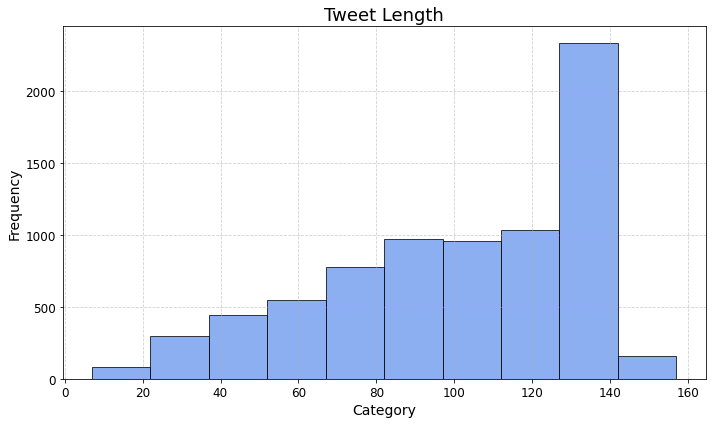

In [4]:
train['tweet_length'] = train['text'].str.len()

train['keyword'] = train['keyword'].fillna(" ")

train['location'] = train['location'].fillna(" ")

print(train['keyword'].value_counts())
print(train['location'].value_counts())
print(train['target'].value_counts())

def plot_histogram(data, title, color):
    plt.figure(figsize=(10, 6))
    plt.hist(data, color=color, edgecolor='black', alpha=0.75)
    plt.title(title, fontsize=18)
    plt.xlabel("Category", fontsize=14)
    plt.ylabel("Frequency", fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.tight_layout()
    plt.show()
    
plot_histogram(train['tweet_length'], title="Tweet Length", color='cornflowerblue')

The Keyword column appears like it could be useful and maybe the tweet length also but the location field is too sparsely populated and many locations are in different formats etc.

The next step is to clean the text for easy comparison and then vectorization.

In [5]:
stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()

def clean_text(text_list):
    cleaned = []
    for text in text_list:
        text = text.lower()
        text = re.sub(r'[^\w\s]', '', text)
        text = re.sub(r'\d+', '', text)
        
        tokens = word_tokenize(text)
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        
        cleaned_text = ' '.join(tokens)
        cleaned.append(cleaned_text)
    return cleaned

train['text']= clean_text(train['text'])

test['text']= clean_text(test['text'])

In [6]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_tfidf = vectorizer.fit_transform(train['text']) 

X_test_tfidf = vectorizer.transform(test['text'])

label_encoder = LabelEncoder()
true_train_labels = label_encoder.fit_transform(train['target'])


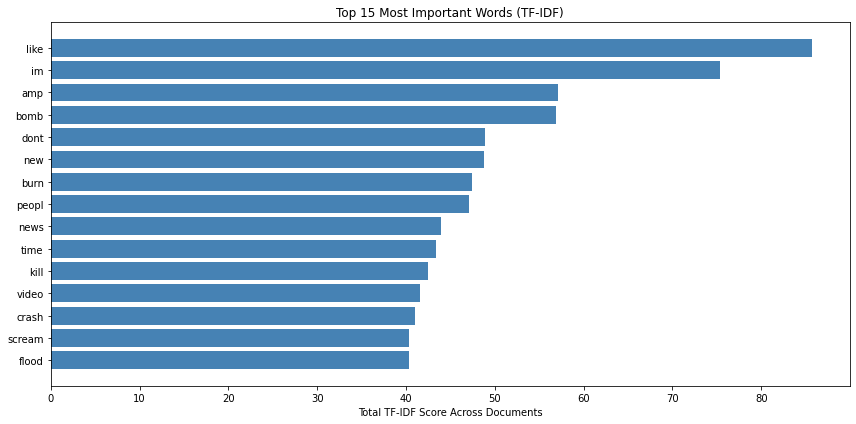

In [7]:
tfidf_scores = np.asarray(X_tfidf.sum(axis=0)).flatten()

feature_names = vectorizer.get_feature_names()

top_n = 15
top_indices = tfidf_scores.argsort()[::-1][:top_n]
top_words = [feature_names[i] for i in top_indices]
top_scores = tfidf_scores[top_indices]

plt.figure(figsize=(12, 6))
plt.barh(top_words[::-1], top_scores[::-1], color='steelblue')
plt.xlabel("Total TF-IDF Score Across Documents")
plt.title(f"Top {top_n} Most Important Words (TF-IDF)")
plt.tight_layout()
plt.show()

### Model build and train

#### Truncated SVD and Logistic Regression

Truncated SVD is a method of reducing the dimensionality of the word martrix which I paired with Logistic regression which is useful for binary classification. 

Grid Search was chosen to optimize my hyperparameters and I also chose to exclude vectorization from the pipeline as we did not need to re vectorize each iteration in gridsearch, further, it will be used for the next method. 

In [9]:

pipeline = Pipeline([
    ('svd', TruncatedSVD(random_state=50)),
    ('clf', LogisticRegression(max_iter=1000))
])

param_grid = {
    'svd__n_components': [10, 100, 500],
    'clf__C': [0.01, 0.1, 1, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search.fit(X_tfidf, train['target'])

print("Best parameters:", grid_search.best_params_)
print("Best CV score:", grid_search.best_score_)

import pandas as pd
results_df = pd.DataFrame(grid_search.cv_results_)
print(results_df[['params', 'mean_test_score']].sort_values(by='mean_test_score', ascending=False))


    

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] clf__C=0.01, svd__n_components=10 ...............................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ................ clf__C=0.01, svd__n_components=10, total=   1.1s
[CV] clf__C=0.01, svd__n_components=10 ...............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.1s remaining:    0.0s


[CV] ................ clf__C=0.01, svd__n_components=10, total=   1.1s
[CV] clf__C=0.01, svd__n_components=10 ...............................
[CV] ................ clf__C=0.01, svd__n_components=10, total=   1.4s
[CV] clf__C=0.01, svd__n_components=10 ...............................
[CV] ................ clf__C=0.01, svd__n_components=10, total=   1.5s
[CV] clf__C=0.01, svd__n_components=10 ...............................
[CV] ................ clf__C=0.01, svd__n_components=10, total=   1.3s
[CV] clf__C=0.01, svd__n_components=100 ..............................
[CV] ............... clf__C=0.01, svd__n_components=100, total=   8.9s
[CV] clf__C=0.01, svd__n_components=100 ..............................
[CV] ............... clf__C=0.01, svd__n_components=100, total=  10.4s
[CV] clf__C=0.01, svd__n_components=100 ..............................
[CV] ............... clf__C=0.01, svd__n_components=100, total=  11.5s
[CV] clf__C=0.01, svd__n_components=100 ..............................
[CV] .

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed: 26.9min finished


Best parameters: {'clf__C': 10, 'svd__n_components': 100}
Best CV score: 0.695526154807192
                                        params  mean_test_score
10    {'clf__C': 10, 'svd__n_components': 100}         0.695526
7      {'clf__C': 1, 'svd__n_components': 100}         0.693556
8      {'clf__C': 1, 'svd__n_components': 500}         0.688566
11    {'clf__C': 10, 'svd__n_components': 500}         0.678584
9      {'clf__C': 10, 'svd__n_components': 10}         0.656777
6       {'clf__C': 1, 'svd__n_components': 10}         0.648107
5    {'clf__C': 0.1, 'svd__n_components': 500}         0.647711
4    {'clf__C': 0.1, 'svd__n_components': 100}         0.637333
3     {'clf__C': 0.1, 'svd__n_components': 10}         0.590438
0    {'clf__C': 0.01, 'svd__n_components': 10}         0.570340
1   {'clf__C': 0.01, 'svd__n_components': 100}         0.570340
2   {'clf__C': 0.01, 'svd__n_components': 500}         0.570340


Now some predictions

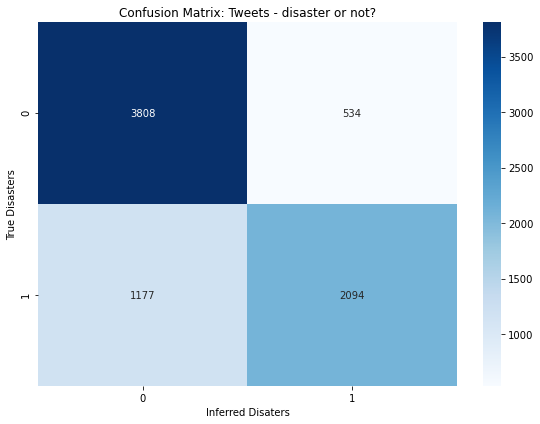

[1 1 1 ... 1 1 1]


In [26]:
best_model = grid_search.best_estimator_


y_train_pred = best_model.predict(X_tfidf)
conf_mat = confusion_matrix(true_train_labels, y_train_pred)

row_ind, col_ind = linear_sum_assignment(-conf_mat)
conf_mat_aligned = conf_mat[:, col_ind]

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_aligned, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"{i}" for i in col_ind])
plt.xlabel("Inferred Disaters")
plt.ylabel("True Disasters")
plt.title("Confusion Matrix: Tweets - disaster or not?")
plt.tight_layout()
plt.show()


print(y_train_pred)


In [27]:
y_test_pred = best_model.predict(X_test_tfidf)

test_submission = pd.DataFrame({
    'id': test['id'],
    'target': y_test_pred
})

test_submission.to_csv('svd_test_predictions.csv', index=False)

#### Truncated SVD and Logistic Regression - Conclusion

This approach gave an F1 score of 76% in test data which appears to be decent amongst peers on Kaggle. The increase in SVD components, especially with 5 fold gridsearch really slows down the modelling. 

I will try manual grid search this time with a purely unsupervised approach.

#### NMF and Clustering

NMF is a powerful method of reducing the dimensionality of the word martrix. I paired this with Clustering which may work as a purely unsupervised approach for binary classification. 

Grid Search was chosen to optimize my hyperparameters and I also chose to exclude vectorization from the pipeline as we did not need to re vectorize each iteration in gridsearch. 

In [29]:
feature_combos = [['frobenius', 'cd', 2], ['frobenius', 'mu', 2], ['kullback-leibler', 'mu', 2],
                  ['frobenius', 'cd', 5], ['frobenius', 'mu', 5], ['kullback-leibler', 'mu', 5],
                  ['frobenius', 'cd', 25], ['frobenius', 'mu', 25], ['kullback-leibler', 'mu', 25],
                 ['frobenius', 'cd', 50], ['frobenius', 'mu', 50], ['kullback-leibler', 'mu', 50]
                 ]
beta_loss, solver, n_components = zip(*feature_combos)
   
ari_train = []
acc_train = []

best_acc_train = 0
best_model = None
best_kmeans = None
best_config = None
best_aligned_train_clusters = None

for n in feature_combos:
    print(n)
    nmf = NMF(n_components=n[2], random_state=50, solver=n[1], beta_loss = n[0])
    W = nmf.fit_transform(X_tfidf)

    kmeans = KMeans(n_clusters=2, random_state=50)
    cluster_labels = kmeans.fit_predict(W)

    conf_mat = confusion_matrix(true_train_labels, cluster_labels)

    row_ind, col_ind = linear_sum_assignment(-conf_mat)
    aligned_clusters = np.zeros_like(cluster_labels)
    for i, j in zip(row_ind, col_ind):
        aligned_clusters[cluster_labels == i] = j
    
    nmf_optimal_accuracy = (aligned_clusters == true_train_labels).mean()
    ari_nmf = adjusted_rand_score(true_train_labels, cluster_labels)
    
    ari_train.append(ari_nmf)
    acc_train.append(nmf_optimal_accuracy)
    
    if nmf_optimal_accuracy > best_acc_train:
        best_acc_train = nmf_optimal_accuracy
        best_model_nmf = nmf
        best_kmeans = kmeans
        best_config = (n[0], n[1], n[2])
        best_aligned_train_clusters = aligned_clusters
        




['frobenius', 'cd', 2]
['frobenius', 'mu', 2]
['kullback-leibler', 'mu', 2]
['frobenius', 'cd', 5]
['frobenius', 'mu', 5]
['kullback-leibler', 'mu', 5]
['frobenius', 'cd', 25]
['frobenius', 'mu', 25]
['kullback-leibler', 'mu', 25]
['frobenius', 'cd', 50]
['frobenius', 'mu', 50]
['kullback-leibler', 'mu', 50]


[0.5812426113227375, 0.5812426113227375, 0.6163141993957704, 0.5734927098384343, 0.5734927098384343, 0.6167082621831078, 0.5734927098384343, 0.5734927098384343, 0.5704715618021805, 0.5734927098384343, 0.5734927098384343, 0.570865624589518]


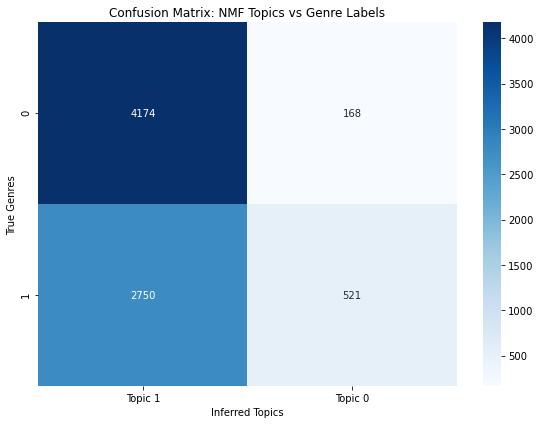

In [30]:
conf_mat_aligned_train = confusion_matrix(true_train_labels, best_aligned_train_clusters)    

print(acc_train)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat_aligned_train, annot=True, fmt='d', cmap='Blues',
            xticklabels=[f"Topic {i}" for i in col_ind])
plt.xlabel("Inferred Topics")
plt.ylabel("True Genres")
plt.title("Confusion Matrix: NMF Topics vs Genre Labels")
plt.tight_layout()
plt.show()



In [33]:
W_test = best_model_nmf.transform(X_test_tfidf)
test_cluster_labels = best_kmeans.predict(W_test)

print(test_cluster_labels)
test_submission_nmf = pd.DataFrame({
    'id': test['id'],
    'target': test_cluster_labels
})

test_submission_nmf.to_csv('nmf_test_predictions.csv', index=False)


[0 0 0 ... 0 1 1]


#### Non Negative Matrix Factorization and K-Means  - Conclusion

This approach was considerably quicker for model generation than my first approach. However, its score of 60% in test data which is considerably worse than my initial approach.  

This shows the limitations of a purely unsupervised approach for a binary prediction model. The K-means approach attempted to divide the tweets in two as cleanly as possible. That does not mean that it divided the tweets into disaster and not disaster tweets. 

### Overall Conclusion

Unsupervised Learning techniques are very powerful, they can tell us new things about our data and simplify it. For a specific Binary classification task though, it is better used in conjunction with a supervised approach which targets the precise breakdown required.  